In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %qtconsole

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)
			
import pandas as pd
import numpy as np
from pathlib import Path		

import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [0]:
from datetime import datetime, timedelta 
from dateutil.relativedelta import relativedelta

In [0]:
url = r'https://raw.githubusercontent.com/klin059/Auckland_traffic_analysis/master/data/merged_data_20190728.csv'
# url = r'data/merged_data_20190728.csv'

In [0]:
df_orig = pd.read_csv(url, parse_dates = ['count_date'])
df = df_orig.copy()
df.sort_values(by = "count_date", inplace = True)
df.head()
df.tail()

,carr_way_no,road_id,road_name,start_name,end_name,location,latest,count_date,adt,latitude,longitude,cway_width,traff_manage_level,Shape__Length
4682,12411.0,40986,COLWILL RD,SPARGO RD,END,1704.0,No,1974-07-12,125.0,-36.832191,174.636777,6.8,"< 10,000 vpd Rural/<15,000 vpd Urban",396.674078
11389,13617.0,40854,GLORIA AVE,OLD TE ATATU RD,GRAHAM AVE,99.0,No,1974-08-11,1823.0,-36.848907,174.650109,11.2,"< 10,000 vpd Rural/<15,000 vpd Urban",113.001344
65,10376.0,40798,HOBSONVILLE RD,LUCKENS RD,WESTPARK DR,1517.0,No,1974-08-11,2163.0,-36.814264,174.630139,9.0,">= 15,000 vpd Urban road, low speed",581.914617
49,10308.0,40798,HOBSONVILLE RD,MOTORWAY OVERBRIDGE (EAST ABUTMENT),OREIL AVE,158.0,No,1974-08-11,3900.0,-36.818091,174.615882,28.0,">= 15,000 vpd Urban road, low speed",199.169213
12333,11261.0,40365,TAIKATA RD,TE ATATU RD RAB,PEACHGROVE RD,30.0,No,1974-08-11,2490.0,-36.841192,174.651345,10.1,"< 10,000 vpd Rural/<15,000 vpd Urban",131.001559


,carr_way_no,road_id,road_name,start_name,end_name,location,latest,count_date,adt,latitude,longitude,cway_width,traff_manage_level,Shape__Length
22943,11585.0,40522,POMARIA RD,KINGDALE RD,LONGBURN RD,448.0,Yes,2019-03-06,6994.0,-36.861600,174.623820,8.6,"< 10,000 vpd Rural/<15,000 vpd Urban",185.273683
22964,13123.0,40909,FAIRDENE AVE,STEPHEN AVE,EDWARDS AVE,308.0,Yes,2019-03-06,3089.0,-36.865612,174.626350,7.5,"< 10,000 vpd Rural/<15,000 vpd Urban",337.605067
22942,11330.0,40389,STEPHEN AVE,POMARIA RD,KONA CRES (NORTH),107.0,Yes,2019-03-06,828.0,-36.863331,174.627693,7.0,<500 vpd (Low Volume),196.603260
22945,11747.0,40624,MILDMAY RD,HARRINGTON RD (AT TEE),LARISSA AVE,215.0,Yes,2019-03-06,294.0,-36.861519,174.617166,6.8,<500 vpd (Low Volume),175.769275
22952,12107.0,40823,HARRINGTON RD,HARRY WARD PL,ASCOT AVE,215.0,Yes,2019-03-06,1568.0,-36.859423,174.619489,7.0,"< 10,000 vpd Rural/<15,000 vpd Urban",113.234506


In [0]:
# # consider only traffic counts after 2010
# df.shape
df = df[df['count_date'] > pd.to_datetime('2009-12-31')]

In [0]:
import re
def add_datepart(df, fldname, drop=False, time=False, errors="raise"):	

    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Dayofyear', 'Week', 'Year', 'Month', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
#     , , 'Day',''Dayofweek''
#             'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [0]:
df.head()

,carr_way_no,road_id,road_name,start_name,end_name,location,latest,count_date,adt,latitude,longitude,cway_width,traff_manage_level,Shape__Length
2020,6933.0,20038,HURSTMERE RD,MINNEHAHA AVE,KITCHENER RD,1315.0,No,2010-01-04,11946.0,-36.777666,174.775108,12.6,">= 15,000 vpd Urban road, low speed",254.802502
3319,6681.0,20001,EAST COAST RD (TAKA/GLENFIELD/E.C,SPENCER RD,JOHN DOWNS DR,8046.0,No,2010-01-04,10089.0,-36.720712,174.724027,13.4,">= 15,000 vpd Urban road, low speed",820.181010
1176,6745.0,20011,GLENFIELD RD,SPEEDY CRES,CORONATION RD,1046.0,No,2010-01-04,16507.0,-36.794472,174.723897,13.0,">= 15,000 vpd Urban road, low speed",426.472519
944,6701.0,20002,LAKE RD (DEVONPORT),BARDIA ST,EVERSLEIGH RD,2623.0,No,2010-01-04,23655.0,-36.802798,174.787569,12.0,">= 15,000 vpd Urban road, low speed",529.999614
4330,8486.0,22135,MOKOIA RD,ROSEBERRY AVE,BALMAIN RD,1261.0,No,2010-01-04,17588.0,-36.810808,174.712481,12.5,">= 15,000 vpd Urban road, low speed",427.289597


In [0]:
# encode cat columns
from sklearn.preprocessing import LabelEncoder
cat_cols = ['carr_way_no', 'road_id', 'road_name', 'start_name', 'end_name', 
            'location', 'latest', 'traff_manage_level']
label_encoders_dict = {}
for col in cat_cols:
    new_le = LabelEncoder()
    df[col] = new_le.fit_transform(df[col])
    label_encoders_dict[col] = new_le
display_all(df.head())

,carr_way_no,road_id,road_name,start_name,end_name,location,latest,count_date,adt,latitude,longitude,cway_width,traff_manage_level,Shape__Length
2020,1803,764,1378,2281,2120,1269,0,2010-01-04,11946.0,-36.777666,174.775108,12.6,3,254.802502
3319,1676,733,814,3359,1960,3291,0,2010-01-04,10089.0,-36.720712,174.724027,13.4,3,820.181010
1176,1712,741,1075,3356,847,1024,0,2010-01-04,16507.0,-36.794472,174.723897,13.0,3,426.472519
944,1686,734,1627,256,1270,2105,0,2010-01-04,23655.0,-36.802798,174.787569,12.0,3,529.999614
4330,2235,1072,1982,3076,279,1220,0,2010-01-04,17588.0,-36.810808,174.712481,12.5,3,427.289597


In [0]:
# one hot encode traff_manage_level
df = pd.get_dummies(df, prefix_sep = "__", columns = ['traff_manage_level'])
df.columns

Index(['carr_way_no', 'road_id', 'road_name', 'start_name', 'end_name',
       'location', 'latest', 'count_date', 'adt', 'latitude', 'longitude',
       'cway_width', 'Shape__Length', 'traff_manage_level__0',
       'traff_manage_level__1', 'traff_manage_level__2',
       'traff_manage_level__3', 'traff_manage_level__4',
       'traff_manage_level__5', 'traff_manage_level__6',
       'traff_manage_level__7'],
      dtype='object')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17826 entries, 2020 to 22952
Data columns (total 21 columns):
carr_way_no              17826 non-null int64
road_id                  17826 non-null int64
road_name                17826 non-null int64
start_name               17826 non-null int64
end_name                 17826 non-null int64
location                 17826 non-null int64
latest                   17826 non-null int64
count_date               17826 non-null datetime64[ns]
adt                      17826 non-null float64
latitude                 17826 non-null float64
longitude                17826 non-null float64
cway_width               17826 non-null float64
Shape__Length            17826 non-null float64
traff_manage_level__0    17826 non-null uint8
traff_manage_level__1    17826 non-null uint8
traff_manage_level__2    17826 non-null uint8
traff_manage_level__3    17826 non-null uint8
traff_manage_level__4    17826 non-null uint8
traff_manage_level__5    17826 non-null u

In [0]:
add_datepart(df, 'count_date')

In [0]:
from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.utils import shuffle
def split_vals(df, n):
    return df[:n].copy(), df[n:].copy()

def rmse(x,y): 
    # calculates r^2
    return math.sqrt(np.square(np.subtract(x,y)).mean())
def get_scores(m, X_train, X_valid, y_train, y_valid):
    # returns rmsq training, r^2 validation, avg accuracy training, avg accuracy validation, oob
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): 
        res.append(m.oob_score_)
    return res

def train_test_split(df, xcols, ycol, train_size_f = 0.75, shuffle_bool = False):
    train_size = int(df.shape[0] * train_size_f)
    if shuffle_bool:
        df_model = shuffle(df)
    else:
        df_model = df.copy()
    X, y = df_model[xcols], df_model[ycol]
    X_train, X_test = split_vals(X, train_size)
    y_train, y_test = split_vals(y, train_size)
    return X_train, X_test, y_train, y_test

def tt_split_by_years(df, xcols, ycol, train_years = [2016, 2017, 2018], test_years = [2019]):
#     train-test split by year
    df_train = df[df.count_Year.isin(train_years)]
    df_test = df[df.count_Year.isin(test_years)]
    X_train, X_test = df_train[xcols], df_test[xcols]
    y_train, y_test = df_train[ycol], df_test[ycol]
    return X_train, X_test, y_train, y_test

def split_by_forward_period(df, xcols, ycol, split_date = '2018-12-31', train_months = 36, test_months = 3):
#     walk forward train-test split
    d = pd.to_datetime(split_date)
    train_lb = d - relativedelta(months = train_months)
    test_ub = d + relativedelta(months = test_months)
    df_train = df[(df.count_date >= train_lb)&(df.count_date < d)]
    df_test = df[(df.count_date >= d)&(df.count_date < test_ub)]
    X_train, X_test = df_train[xcols], df_test[xcols]
    y_train, y_test = df_train[ycol], df_test[ycol]
    return X_train, X_test, y_train, y_test

def expanding_window_split(df, xcols, ycol, split_date = '2018-01-01', test_months = 2):
    # expanding window split
    d = pd.to_datetime(split_date)
    test_ub = d + relativedelta(months = test_months)
    df_train = df[df.count_date < d]
    df_test = df[(df.count_date >= d)&(df.count_date < test_ub)]
    X_train, X_test = df_train[xcols], df_test[xcols]
    y_train, y_test = df_train[ycol], df_test[ycol]
    return X_train, X_test, y_train, y_test

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [0]:
df.columns

Index(['carr_way_no', 'road_id', 'road_name', 'start_name', 'end_name',
       'location', 'latest', 'count_date', 'adt', 'latitude', 'longitude',
       'cway_width', 'Shape__Length', 'traff_manage_level__0',
       'traff_manage_level__1', 'traff_manage_level__2',
       'traff_manage_level__3', 'traff_manage_level__4',
       'traff_manage_level__5', 'traff_manage_level__6',
       'traff_manage_level__7', 'count_Dayofyear', 'count_Week', 'count_Year',
       'count_Month', 'count_Is_month_end', 'count_Is_month_start',
       'count_Is_quarter_end', 'count_Is_quarter_start', 'count_Is_year_end',
       'count_Is_year_start', 'count_Elapsed'],
      dtype='object')

In [0]:
xcols = [col for col in df.columns]
xcols.remove('adt')
xcols.remove('road_name')
xcols.remove('count_date')
xcols.remove('latest')
ycol = 'adt'

In [0]:
# expanding_window_split performs better than sliding window
X_train, X_test, y_train, y_test = split_by_forward_period(df, xcols, ycol, split_date = '2018-05-31', train_months = 36, test_months = 2)
m = RandomForestRegressor(n_estimators=300, max_depth=28, max_features=0.5, oob_score= True, random_state=1, n_jobs  = -1)
m.fit(X_train, y_train)
get_scores(m, X_train, X_test, y_train, y_test)
# m.score(X_train, y_train)
# m.score(X_test, y_test)
# m.oob_score_
# rf_feat_importance(m, X_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
                      oob_score=True, random_state=1, verbose=0,
                      warm_start=False)

[1056.08629769755,
 4615.050130968227,
 0.9927399704362636,
 0.7198623741925434,
 0.9473770599010185]

In [0]:
X_train, X_test, y_train, y_test = expanding_window_split(df, xcols, ycol, split_date = '2018-05-31', test_months = 2)
m = RandomForestRegressor(n_estimators=300, max_depth=28, max_features=0.5, oob_score= True, random_state=1, n_jobs  = -1)
m.fit(X_train, y_train)
get_scores(m, X_train, X_test, y_train, y_test)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
                      oob_score=True, random_state=1, verbose=0,
                      warm_start=False)

[821.4664352633803,
 4503.942253645377,
 0.9965181228659281,
 0.7331886961522794,
 0.9747351274855336]

In [0]:
rf_feat_importance(m, X_train)

,cols,imp
11,traff_manage_level__2,0.271832
7,cway_width,0.199340
1,road_id,0.123585
4,location,0.063909
0,carr_way_no,0.049712
12,traff_manage_level__3,0.047307
5,latitude,0.036543
17,count_Dayofyear,0.032763
9,traff_manage_level__0,0.032636
6,longitude,0.031407


Got a much better results once road info are added into the model

In [0]:
m = RandomForestRegressor(n_estimators=300, max_depth=28, max_features=0.5, oob_score= True, random_state=1, n_jobs  = -1)
def get_list_of_split_dates(df, start_date = '2017-01-01', test_months = 2):
    d = pd.to_datetime(start_date)
    last_date = df.count_date.max()
    test_ub = d + relativedelta(months = test_months)
    list_of_split_dates = [d]
    while test_ub < last_date:  
        list_of_split_dates.append(test_ub)
        test_ub += relativedelta(months = test_months)
    return list_of_split_dates

def back_testing(df, xcols, ycol, list_of_split_dates, test_months = 2):
    results = []
    for split_date in list_of_split_dates:
        X_train, X_test, y_train, y_test = expanding_window_split(df, xcols, ycol, split_date = split_date, test_months = test_months)
        m.fit(X_train, y_train)
        r = get_scores(m, X_train, X_test, y_train, y_test)
        results.append(r)
    return np.vstack(results)
list_of_split_dates = get_list_of_split_dates(df, start_date =  '2017-01-01', test_months = 2)
print(list_of_split_dates)
results = back_testing(df, xcols, ycol, list_of_split_dates, test_months = 2)

[Timestamp('2017-01-01 00:00:00'), Timestamp('2017-03-01 00:00:00'), Timestamp('2017-05-01 00:00:00'), Timestamp('2017-07-01 00:00:00'), Timestamp('2017-09-01 00:00:00'), Timestamp('2017-11-01 00:00:00'), Timestamp('2018-01-01 00:00:00'), Timestamp('2018-03-01 00:00:00'), Timestamp('2018-05-01 00:00:00'), Timestamp('2018-07-01 00:00:00'), Timestamp('2018-09-01 00:00:00'), Timestamp('2018-11-01 00:00:00'), Timestamp('2019-01-01 00:00:00'), Timestamp('2019-03-01 00:00:00')]


In [0]:
results  # rmse_train rmse_test, r2_train, r2_test, oob

array([[8.22877468e+02, 2.08510159e+03, 9.96926026e-01, 9.41559829e-01,
        9.77336602e-01],
       [8.18611094e+02, 3.00234621e+03, 9.96922549e-01, 8.97705065e-01,
        9.77374914e-01],
       [8.15963954e+02, 3.77634032e+03, 9.96901052e-01, 8.69469225e-01,
        9.77225519e-01],
       [8.16997179e+02, 2.41211920e+03, 9.96857407e-01, 9.09550947e-01,
        9.76978912e-01],
       [8.13895842e+02, 2.92087190e+03, 9.96827514e-01, 8.84511478e-01,
        9.76758605e-01],
       [8.11658871e+02, 3.09021960e+03, 9.96797287e-01, 8.69620949e-01,
        9.76527877e-01],
       [8.10444309e+02, 2.35029104e+03, 9.96755384e-01, 8.96527154e-01,
        9.76277528e-01],
       [8.06797246e+02, 3.03755994e+03, 9.96742738e-01, 8.33012545e-01,
        9.76213034e-01],
       [8.05521133e+02, 4.29219408e+03, 9.96688354e-01, 7.83049473e-01,
        9.75808188e-01],
       [8.30785881e+02, 2.76667774e+03, 9.96407626e-01, 8.83665177e-01,
        9.73954455e-01],
       [8.27034107e+02, 3.0641

In [0]:
results.mean(axis = 0)

array([8.18168170e+02, 2.79326966e+03, 9.96659430e-01, 8.68554936e-01,
       9.75607373e-01])

In [0]:
!pip install pdpbox

In [0]:
from pdpbox import pdp, info_plots

In [0]:
xcols2 = xcols.copy()
xcols2.remove('count_Elapsed')
# train on the full dataset
m.fit(df[xcols2], df[ycol])
m.oob_score_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
                      oob_score=True, random_state=1, verbose=0,
                      warm_start=False)

0.9734445510332033

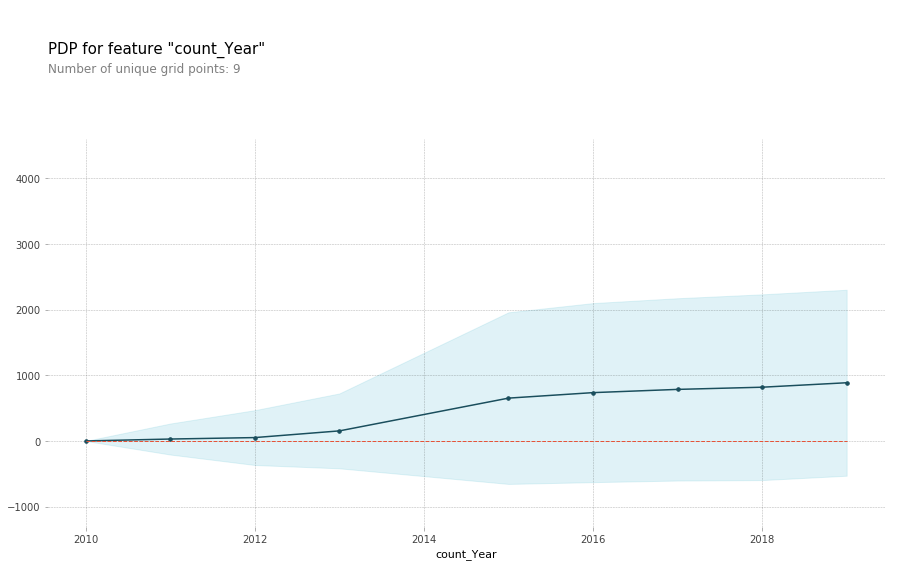

In [0]:
pdp_year = pdp.pdp_isolate(
    model=m, dataset=df[xcols2], model_features=xcols2, feature='count_Year'
)
fig, axes = pdp.pdp_plot(pdp_year, 'count_Year')

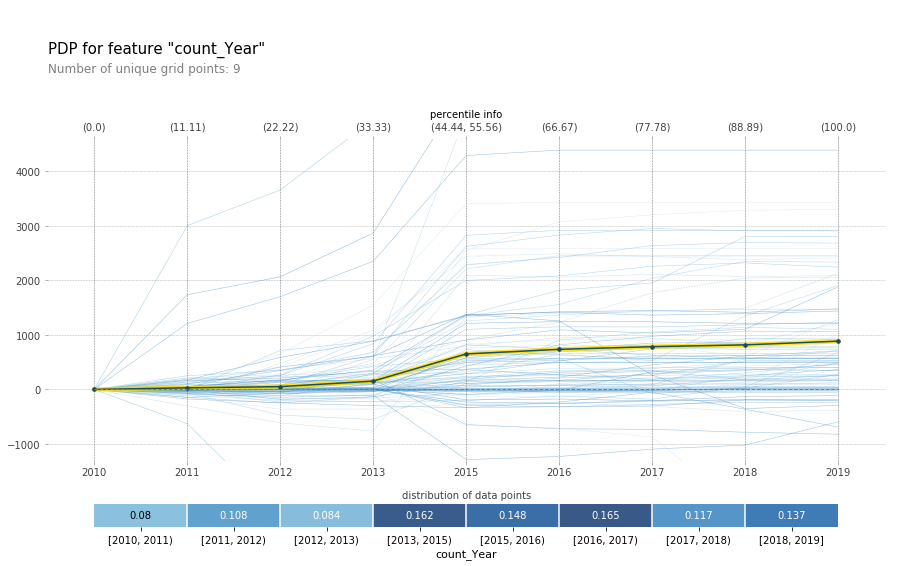

In [0]:
pdp_year = pdp.pdp_isolate(
    model=m, dataset=df[xcols2], model_features=xcols2, feature='count_Year'
)
fig, axes = pdp.pdp_plot(
    pdp_year, 'count_Year', plot_lines=True, frac_to_plot=100, x_quantile=True, 
    plot_pts_dist=True, show_percentile=True
)